# 02. Handson Machine Learning: Classifcation

In [8]:

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [1]:
# download MNIST data set (images labeded with digit it represents)

from sklearn.datasets import fetch_openml
minist = fetch_openml('mnist_784', version=1)
minist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = minist["data"], minist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

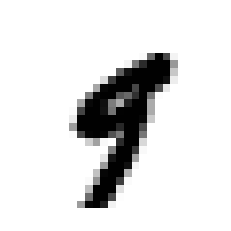

In [5]:
# display one instance

'''
plt.imshow:
https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html
'''

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary
          , interpolation = 'nearest')
plt.axis('off')
plt.show()

In [6]:
y[36000]

'9'

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


FileNotFoundError: [Errno 2] No such file or directory: './images/classification/more_digits_plot.png'

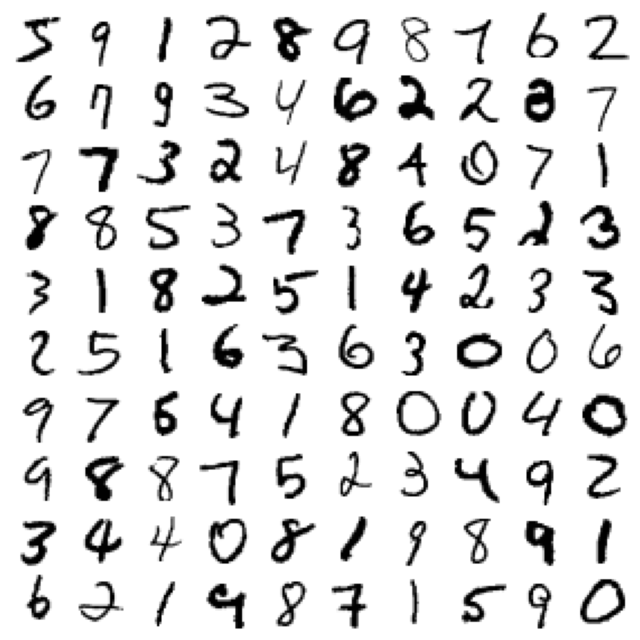

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

# create train and test set

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [32]:
"""
np.random.permutation():
Randomly permute a sequence, or return a permuted range.
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.permutation.html
"""

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

only identify one digit '5'

In [42]:
y_train_5 = (y_train == '5')

In [43]:
y_test_5 = (y_test == '5')

In [44]:
'''
SGDClassifier:
implements regularized linear models with stochastic gradient descent (SGD) learning
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
'''

# use stochastic Gradient Descent(SGD) classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
sgd_clf.predict([some_digit])

array([False])

# performance measures

### Measuring accuracy using cross-validation

In [47]:
# implement cross-validation

"""
for details
official doc:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

differences between StratifiedKFold and StratifiedShuffleSplit:
https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn
"""

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # clone: does a deep copy of the model in an estimator without actually copying attached data
    # https://scikit-learn.org/stable/modules/generated/sklearn.base.clone.html
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96985
0.96555
0.96645


In [48]:
# using K-fold cross-validation with three folds

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.96985, 0.96555, 0.96645])

In [49]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [50]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.90845, 0.9087 , 0.9118 ])

This demonstrate that accuracy is not the best performance measurement for classification when you have skewed dataset

# Confusion Matrix

In [51]:
'''
differences between cross_val_predict() and cross_val_score()
cross_val_predict() gives a clean set of prediction on each cv folder
cross_val_score() gives the evaluation scores
'''

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [52]:
'''
from confusion matrix output
row = actual class
column = predict class
'''

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53990,   589],
       [ 1374,  4047]])

In [53]:
# example of perfect classifier

y_train_perfect_predictions = y_train_5
confusion_matrix (y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In [54]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8729508196721312

In [55]:
recall_score(y_train_5, y_train_pred)

0.746541228555617

In [57]:
4047/(4047+589)

0.8729508196721312

In [58]:
4047/(4047+1374)

0.746541228555617

In [59]:
# f1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.804812568360346

In [62]:
2/(1/0.8729508196721312 + 1/0.746541228555617)

0.804812568360346

## precision/recall trade-off

In [63]:
some_digit

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [64]:
'''
decision_function() let you take different threshold for each instance
'''
y_scores = sgd_clf.decision_function([some_digit])

In [65]:
y_scores

array([-8843.02055229])

In [66]:
threshold = 0

In [69]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

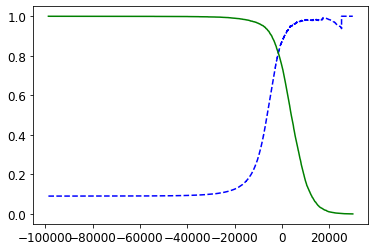

In [81]:
# to decide which threshold you use

# step 1: get all prediction instance and return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

# step 2: compute precision and recall for all possible thresholds
# thresholds returns all possible thresholds for the dataset
# doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# precision,recall: array, shape = [n_thresholds + 1], that's why we need to exclude the last elements
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# plot precision and recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

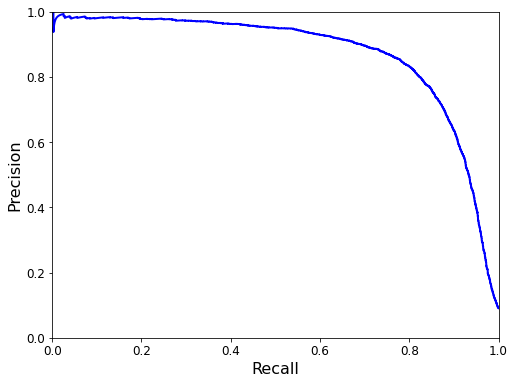

In [83]:
# or plot recalls and precisions in the same graph
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# save_fig("precision_vs_recall_plot")
plt.show()

In [84]:
# if you want to specify at least X% precision
# np.argmax(): Returns the first indices of the maximum values along an axis.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [130]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [131]:
precision_score(y_train_5, y_train_pred_90)

0.9001679865610751

In [132]:
recall_score(y_train_5, y_train_pred_90)

0.6919387566869581

# ROC Curve

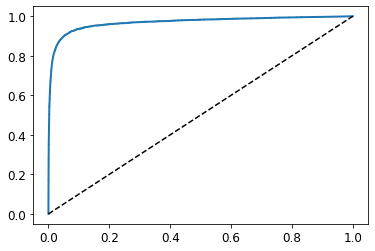

In [140]:
# compute true positive rate and false positive rate
# doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# only effective when using a binary classifier
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# do the plot
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    # plt.plot(point_A, point_B): point A = X, point B = X
    
plot_roc_curve(fpr, tpr)
plt.show()

In [143]:
# compare different classifier using roc: using auc(area under the roc curve)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.968493311004681

In [144]:
# use random forest to compare roc and aud with SGD
# doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Predict class probabilities for X.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3
                                   , method = "predict_proba"
                                   )

In [146]:
y_probas_forest

array([[0.03, 0.97],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.74, 0.26]])

In [150]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

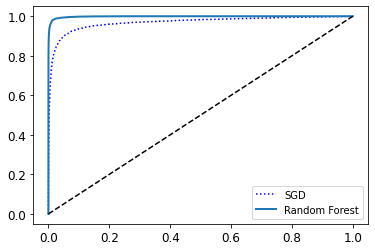

In [151]:
# plot roc SGD vs RF
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [152]:
roc_auc_score(y_train_5, y_scores_forest)

0.9985605231064885

# Multiclass Classfication

## Sklearn automatically runs OvR (one-versus-rest) or OvO (one-versus-one) depending on the algorithmn

In [153]:
# try SVM classifier
# some reading:https://stackoverflow.com/questions/27912872/what-is-the-difference-between-svc-and-svm-in-scikit-learn

from sklearn.svm import SVC
# The multiclass support is handled according to a one-vs-one scheme.

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array(['9'], dtype=object)

In [154]:
# call decision_function(), returns 10 scores per instance for each class (number 0 - 9)

some_digit_scores = svm_clflf_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.70506747,  4.89594223, -0.30950635,  4.1618546 ,  8.30179677,
         3.10412223,  0.6994861 ,  7.25323597,  6.26257797,  9.30853176]])

In [155]:
# see the highest score class
np.argmax(some_digit_scores)

9

In [156]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [158]:
svm_clf.classes_[9]

'9'

In [159]:
# try OneVsRestClassifier

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array(['9'], dtype='<U1')

In [160]:
len(ovr_clf.estimators_)

10

In [161]:
# train SGDClassifier

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [162]:
sgd_clf.decision_function([some_digit])

array([[-37709.10753809, -19634.13677001, -23351.76818131,
         -4358.84749864,   1462.80068841, -10520.07823435,
        -40213.29450963,  -6932.18976564,  -2955.08963095,
         -4175.99586329]])

In [163]:
# cross validation for classifier evaluate

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.86655, 0.85475, 0.8726 ])

In [165]:
# scale the input can help with better result score

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.9035 , 0.90085, 0.89465])

# Error analysis
This can be done after you found a promising model and trying to find way to improve it

### First, Look at confusion matrix

In [ ]:
# make predictions using cross_val_predict() function, then call confusion_matrix() function

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

In [ ]:
# use graph to see confusion matrix more clearly

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [ ]:
# plot errors

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

In [ ]:
# fill the diagonal with zeros to keep only the errors, and plot the result

np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()
# row represents the actual classes, column represents predicted classes

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification
In some cases you may want your classiffier to output multiply classes for each instance

In [ ]:
# try a simple multilabel classification

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
# this classifier outputs two labels

knn_clf.predict([some_digit])

In [ ]:
# use f1 score to evaluate the multilabel classifier
# f1_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

# Multioutput-multiclass classification
A generalization of multilabel classification where each level can be multiclass

In [ ]:
# first add some noise to dataset
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mode = X_train + noise
noise = np.random.randint(0, 100, (len(X_train), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mode = X_test

In [ ]:
# to see we add some noise 

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
# now train the classifier to make it clean the image

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mode[some_index]])
plot_digit(clean_digit)